In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env('OPENAI_API_KEY')

In [ ]:
import os
CURRENT_DIR = os.getcwd()
ROOT = os.path.dirname(CURRENT_DIR)
print("current" , CURRENT_DIR)
print("root" , ROOT)

current d:\Customer_support_bot\notebooks
root d:\Customer_support_bot
d:\Customer_support_bot\db


In [12]:
import os
import shutil
import requests
import sqlite3
import pandas as pd

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
backup_file = "travel2.backup.sqlite"
directory = os.path.join(ROOT, "db")

print(directory)


overwrite = False

os.makedirs(directory, exist_ok=True)
local_path = os.path.join(directory, local_file)
backup_path = os.path.join(directory, backup_file)

print(local_path)
print(backup_path)

if overwrite or not os.path.exists(local_path):
    print(f"Downloading database to {local_path}...")
    response = requests.get(db_url)
    response.raise_for_status()

    
    with open(local_path, 'wb') as f:
        f.write(response.content)
    shutil.copy(local_path, backup_path)
    print("Download and backup complete. ✅")
else:
    print("Database already exists. Skipping download.")



d:\Customer_support_bot\db
d:\Customer_support_bot\db\travel2.sqlite
d:\Customer_support_bot\db\travel2.backup.sqlite
Database already exists. Skipping download.


In [3]:
tables = {}
try:
    with sqlite3.connect(local_path) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
        table_names = [table[0] for table in cursor.fetchall()]

        print(f"Loading tables from {local_path}...")

        for table_name in table_names:
            df = pd.read_sql_query(f'SELECT * FROM {table_name}' , conn)

            tables[table_name] = df
            print(f" - Loaded table '{table_name}'")

except (sqlite3.Error, pd.errors.DatabaseError) as e:
        print(f"An error occurred: {e}")

Loading tables from db\travel2.sqlite...
 - Loaded table 'aircrafts_data'
 - Loaded table 'airports_data'
 - Loaded table 'boarding_passes'
 - Loaded table 'bookings'
 - Loaded table 'flights'
 - Loaded table 'seats'
 - Loaded table 'ticket_flights'
 - Loaded table 'tickets'
 - Loaded table 'car_rentals'
 - Loaded table 'hotels'
 - Loaded table 'trip_recommendations'


In [4]:
if 'aircrafts_data' in tables:
    print("\n--- Viewing the first 5 rows of the 'flights' table ---")
    aircraft_df = tables['aircrafts_data']
    print(aircraft_df)


--- Viewing the first 5 rows of the 'flights' table ---
  aircraft_code                model  range
0           773       Boeing 777-300  11100
1           763       Boeing 767-300   7900
2           SU9  Sukhoi Superjet-100   3000
3           320      Airbus A320-200   5700
4           321      Airbus A321-200   5600
5           319      Airbus A319-100   6700
6           733       Boeing 737-300   4200
7           CN1   Cessna 208 Caravan   1200
8           CR2   Bombardier CRJ-200   2700


In [5]:
for key, val in tables.items():
    print(f"--- First 5 rows of the '{key}' table ---")
    print(val.head())
    print("\n") # Add a newline for better spacing

--- First 5 rows of the 'aircrafts_data' table ---
  aircraft_code                model  range
0           773       Boeing 777-300  11100
1           763       Boeing 767-300   7900
2           SU9  Sukhoi Superjet-100   3000
3           320      Airbus A320-200   5700
4           321      Airbus A321-200   5600


--- First 5 rows of the 'airports_data' table ---
  airport_code                                      airport_name         city  \
0          ATL  Hartsfield-Jackson Atlanta International Airport      Atlanta   
1          PEK             Beijing Capital International Airport      Beijing   
2          DXB                       Dubai International Airport        Dubai   
3          LAX                 Los Angeles International Airport  Los Angeles   
4          HND                              Tokyo Haneda Airport        Tokyo   

            coordinates             timezone  
0   [33.6407, -84.4277]     America/New_York  
1   [40.0799, 116.6031]        Asia/Shanghai  
2    

In [6]:
def update_dates(file):
    shutil.copy(backup_path, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_path)


In [7]:
import re
import numpy
import langchain_google_genai
import langchain_groq
from langchain_core.tools import tool

In [8]:
response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

In [9]:
print(faq_text)

## Invoice Questions

1. Can I receive an invoice for my booked flight?

Yes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.

2. Do I need to reconfirm my flight?

No, reconfirmation of SWISS flights is not required.

3. Can I check for availability and fares without booking a flight?

Yes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.

4. What are the flight tariff categories?

The letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.

5. Where can I find the fare conditions for my booked tickets?

The fare co

In [10]:
docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]

In [11]:
docs

[{'page_content': '## Invoice Questions\n\n1. Can I receive an invoice for my booked flight?\n\nYes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.\n\n2. Do I need to reconfirm my flight?\n\nNo, reconfirmation of SWISS flights is not required.\n\n3. Can I check for availability and fares without booking a flight?\n\nYes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.\n\n4. What are the flight tariff categories?\n\nThe letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.\n\n5. Where can I find the fare condition

In [12]:
import os
import re
import requests
from dotenv import load_dotenv

from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

load_dotenv()


print("Loading and parsing the FAQ document...")
response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text
docs_as_strings = re.split(r"(?=\n##)", faq_text)
docs = [Document(page_content=txt) for txt in docs_as_strings]
print(f"Loaded {len(docs)} document chunks.")


class VectorStoreRetriever:
    """A retriever that encapsulates a Chroma vector store."""
    def __init__(self, vector_store: Chroma):
        self.vector_store = vector_store

    @classmethod
    def from_documents(cls, docs: list[Document], embeddings, persist_directory: str):
        vector_store = Chroma.from_documents(
            documents=docs,
            embedding=embeddings,
            persist_directory=persist_directory,
        )
        return cls(vector_store)

    def query(self, query: str, k: int = 5) -> list[Document]:
        return self.vector_store.similarity_search(query, k=k)



persist_directory = os.path.join(os.getcwd(), "db", "chroma_db") 


embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

if os.path.exists(persist_directory):
    print("\nLoading existing OpenAI vector store from disk...")
    vector_store = Chroma(
        persist_directory=persist_directory, embedding_function=embeddings
    )
    retriever = VectorStoreRetriever(vector_store)
else:
    print("\nCreating new vector store with OpenAI embeddings...")
    retriever = VectorStoreRetriever.from_documents(
        docs=docs, embeddings=embeddings, persist_directory=persist_directory
    )
    print(f"Vector store created and saved to '{persist_directory}'")



@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted."""
    docs_result = retriever.query(query, k=2)
    return "\n\n".join([doc.page_content for doc in docs_result])

Loading and parsing the FAQ document...
Loaded 10 document chunks.

Loading existing OpenAI vector store from disk...


In [13]:
print("\n--- Testing the lookup_policy tool ---")
policy_info = lookup_policy.invoke("Can i travel with pet?")
print("\n--- Policy Lookup Result ---")
print(policy_info)


--- Testing the lookup_policy tool ---

--- Policy Lookup Result ---

## Booking and Cancellation

1. How can I change my booking?
	* The ticket number must start with 724 (SWISS ticket no./plate).
	* The ticket was not paid for by barter or voucher (there are exceptions to voucher payments; if the ticket was paid for in full by voucher, then it may be possible to rebook online under certain circumstances. If it is not possible to rebook online because of the payment method, then you will be informed accordingly during the rebooking process).
	* There must be an active flight booking for your ticket. It is not possible to rebook open tickets or tickets without the corresponding flight segments online at the moment.
	* It is currently only possible to rebook outbound (one-way) tickets or return tickets with single flight routes (point-to-point).
2. Which tickets/bookings cannot be rebooked online currently?
	* Bookings containing flight segments with other airlines
	* Bookings containi

# Tools 

In [14]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

## Car Rental Tools

In [15]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

## Hotels

In [16]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

### Excursion

In [17]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book an excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

# Utilities

In [18]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

# Single node Adgent

In [19]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [20]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_tavily import TavilySearch
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            configuration = config.get("configurable", {})
            passenger_id = configuration.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

part_1_tools = [
    TavilySearch(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [21]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = InMemorySaver()
part_1_graph = builder.compile(checkpointer=memory)

In [22]:
part_1_graph

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [23]:
import shutil
import uuid

# Let's create an example conversation a user might have with the assistant
tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (698b1e37-566b-4704-903a-bd661e4c1f06)
 Call ID: 698b1e37-566b-4704-903a-bd661e4c1f06
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "7240005432906569", "book_ref": "C46E9F", "flight_id": 19250, "flight_no": "LX0112", "departure_airport": "CDG", "arrival_airport": "BSL", "scheduled_departure": "2025-09-19 23:57:42.225581-04:00", "scheduled_arrival": "2025-09-20 01:27:42.225581-04:00", "seat_no": "18E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

Your flight LX0112 from Paris (CDG) to Basel (BSL) is scheduled to depart at 23:57:42 on September 19, 2025, and arrive at 01:27:42 on September 2

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 17.561238619s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 17
}
].


================================== Ai Message ==================================

I haven't searched for "Upper Midscale" hotels yet. I will do that now. Please specify if you have any other preferences for the hotel besides being "nice" and "affordable," such as specific amenities or a more precise location within Basel.

Once I have the search results, I will present them to you, and then you can choose which one you'd like to book.
================================ Human Message =================================

yes go ahead and book anything that's moderate expense and has availability.


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 12.226429197s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 12
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<lo

================================== Ai Message ==================================
Tool Calls:
  search_hotels (32198225-82cf-40a8-a8bb-7e8b024894f7)
 Call ID: 32198225-82cf-40a8-a8bb-7e8b024894f7
  Args:
    location: Basel
    checkin_date: 2025-09-23
    price_tier: Upper Midscale
    checkout_date: 2025-09-30
  search_hotels (40abdc9c-26f9-4917-b785-723d2dba116d)
 Call ID: 40abdc9c-26f9-4917-b785-723d2dba116d
  Args:
    location: Basel
    checkin_date: 2025-09-23
    price_tier: Upscale
    checkout_date: 2025-09-30
================================= Tool Message =================================
Name: search_hotels

[{"id": 1, "name": "Hilton Basel", "location": "Basel", "price_tier": "Luxury", "checkin_date": "2024-04-22", "checkout_date": "2024-04-20", "booked": 0}, {"id": 3, "name": "Hyatt Regency Basel", "location": "Basel", "price_tier": "Upper Upscale", "checkin_date": "2024-04-02", "checkout_date": "2024-04-20", "booked": 0}, {"id": 8, "name": "Holiday Inn Basel", "location"

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 38.143545031s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
].


================================== Ai Message ==================================

I have successfully booked the Kunstmuseum Basel excursion for you. Please note that the booking is for the excursion itself, and I don't have the functionality to specify a particular day for the booking. You will need to arrange your visit to the museum on your second day in Basel (September 24, 2025) directly with the museum if they require a specific timed entry.


# Intreput for Confirmation

In [28]:
from typing import Annotated 

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_tavily import TavilySearch
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable , RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage , add_messages

class State(TypedDict):
    messages : Annotated[list[AnyMessage] , add_messages]
    user_info : str

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable
    
    def __call__(self, state: State , config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # if empty response then call again for same message
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state['messages'] + [("user" , "Respond with a real output.")]
                state = {**state , "messages" : messages}
            else:
                break

        
        return {"messages" : [result]}  

        
# llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4-turbo-preview")


assistant_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)


part_2_tools = [
    TavilySearch(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

In [29]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = InMemorySaver()
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "tools" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["tools"],
)

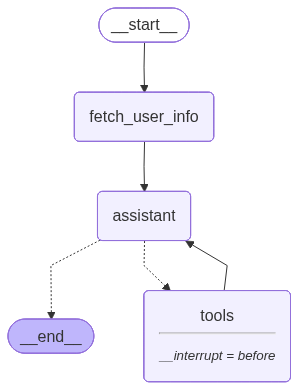

In [30]:
part_2_graph

In [31]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight is scheduled to depart on September 20, 2025, at 00:10 local time from Charles de Gaulle Airport (CDG) and will arrive at EuroAirport Basel Mulhouse Freiburg (BSL) at 01:40 local time.  Please make sure to arrive at the airport well before the departure time to complete all necessary pre-flight processes. Safe travels!
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.
================================== Ai Message ==================================
Tool Calls:
  lookup_policy (call_Kjo9rkxMo11gjydfOMhr8Pr6)
 Call ID: call_Kjo9rkxMo11gjydfOMhr8Pr6
  Args:
    query: flight change
================================ Human Message =================================

Update m